In this notebook we explore different approaches to classification.  First let's make a function to generate some data for classification.

In [21]:
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
from matplotlib.colors import ListedColormap
import sklearn.neighbors
import sklearn.cross_validation
import sklearn.metrics
import sklearn.lda
import sklearn.svm
import sklearn.linear_model
from sklearn.model_selection import GridSearchCV,KFold,StratifiedKFold,LeaveOneOut
from sklearn.metrics import classification_report

n=100

def make_class_data(mean=[50,110],multiplier=1.5,var=[[10,10],[10,10]],cor=-0.4,N=100):
    """
    generate a synthetic classification data set with two variables
    """
    cor=numpy.array([[1.,cor],[cor,1.]])
    var1=numpy.array([[var[0][0],0],[0,var[0][1]]])
    cov1=var1.dot(cor).dot(var1)
    d1=numpy.random.multivariate_normal(mean,cov1,int(N/2))
    var2=numpy.array([[var[1][0],0],[0,var[1][1]]])
    cov2=var2.dot(cor).dot(var2)
    d2=numpy.random.multivariate_normal(numpy.array(mean)*multiplier,cov2,int(N/2))
    d=numpy.vstack((d1,d2))
    cl=numpy.zeros(N)
    cl[:(N/2)]=1
    return cl,d

Let's make some data and plot them (with different markers for the two classes).

[  50.69521155  109.76719266]
[  56.15732766  118.61004032]


/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


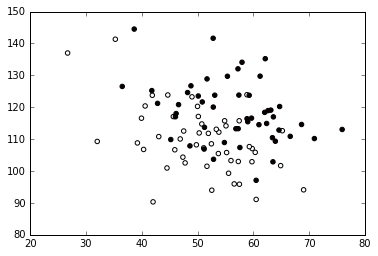

In [13]:
cl,d=make_class_data(multiplier=[1.1,1.1],N=n)
print(numpy.mean(d[:50,:],0))
print(numpy.mean(d[50:,:],0))

plt.scatter(d[:,0],d[:,1],c=cl,cmap=matplotlib.cm.hot)

Now let's look at some different classification methods. 

First let's create a function that can take a dataset and a classifier and show us the "decision surface" - that is, which category is predicted for each value of the variables.

In [14]:
def plot_cls_with_decision_surface(d,cl,clf,h = .25 ):
    """Plot the decision boundary. For that, we will assign a color to each
    point in the mesh [x_min, m_max]x[y_min, y_max].
    h= step size in the grid
    """
    fig=plt.figure()
    x_min, x_max = d[:, 0].min() - 1, d[:, 0].max() + 1
    y_min, y_max = d[:, 1].min() - 1, d[:, 1].max() + 1
    xx, yy = numpy.meshgrid(numpy.arange(x_min, x_max, h),
                         numpy.arange(y_min, y_max, h))
    Z = clf.predict(numpy.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(d[:, 0], d[:, 1], c=cl, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    return fig

#### Nearest neighbor classifier

In the nearest neighbor classifier, we classify new datapoints by looking at which points are nearest in the training data.  In the simplest case we could look at a single neighbor; try setting n_neighbors to 1 in the following cell and look at the results. Then try increasing the value (e.g. try 10, 20, and 40). What do you see as the number of neighbors increases?

We call the nearest neighbor classifier a *nonparametric* method.  This doesn't mean that it has no parameters; to the contrary, it means that the number of parameters is not fixed, but grows with the amount of data.

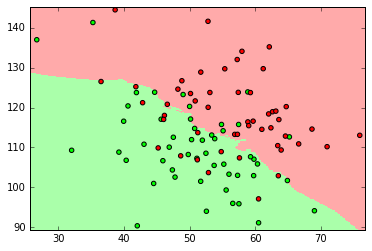

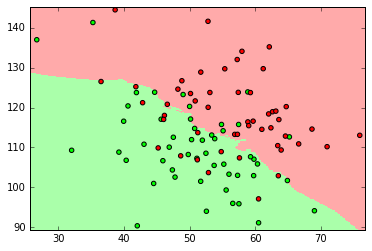

In [15]:
# adapted from http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#example-neighbors-plot-classification-py

n_neighbors = 40

 # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
clf = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
clf.fit(d, cl)

plot_cls_with_decision_surface(d,cl,clf)


Now let's write a function to perform cross-validation and compute prediction accuracy.


In [16]:
def classify(d,cl,clf,cv):
    pred=numpy.zeros(n)
    for train,test in cv.split(d,cl):
        clf.fit(d[train,:],cl[train])
        pred[test]=clf.predict(d[test,:])
    return sklearn.metrics.accuracy_score(cl,pred),sklearn.metrics.confusion_matrix(cl,pred)

Apply that function to the nearest neighbors problem.  We can look at accuracy (how often did it get the label right) and also look at the *confusion matrix* which shows each type of outcome.

In [17]:
n_neighbors=40
clf=sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')
# use stratified k-fold crossvalidation, which keeps the proportion of classes roughly
# equal across folds
cv=StratifiedKFold(8)
acc,confusion=classify(d,cl,clf,cv)
print('accuracy = %f'%acc)
print('confusion matrix:')
print(confusion)

accuracy = 0.710000
confusion matrix:
[[35 15]
 [14 36]]


__Exercise:__  Loop through different levels of n_neighbors (from 1 to 30) and compute the accuracy.

Now write a loop that does this using 100 different randomly generated datasets, and plot the mean across datasets.  This will take a couple of minutes to run.

/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


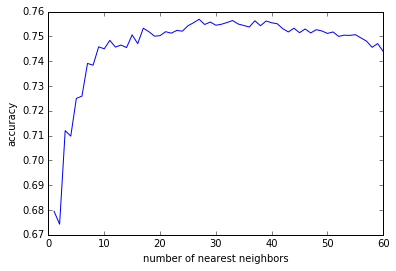

In [19]:
nn_range = range(1,61)

accuracy_knn=numpy.zeros((100,len(nn_range)))
for x in range(100):
    ds_cl,ds_x=make_class_data(multiplier=[1.1,1.1],N=n)
    ds_cv=StratifiedKFold(8)
    for i in nn_range:
        clf=sklearn.neighbors.KNeighborsClassifier(i, weights='uniform')
        accuracy_knn[x,i-1],_=classify(ds_x,ds_cl,clf,ds_cv)
plt.plot(nn_range,numpy.mean(accuracy_knn,0))
plt.xlabel('number of nearest neighbors')
plt.ylabel('accuracy')

#### Linear discriminant analysis

Linear discriminant analysis is an example of a *parametric* classification method.  For each class it fits a Gaussian distribution, and then makes its classification decision on the basis of which Gaussian has the highest density at each point.

accuracy = 0.750000
confusion matrix:
[[35 15]
 [10 40]]


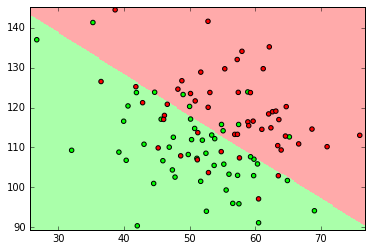

In [23]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf=sklearn.lda.LDA(store_covariance=True) #QuadraticDiscriminantAnalysis()
cv=LeaveOneOut()
acc,confusion=classify(d,cl,clf,cv)
print('accuracy = %f'%acc)
print('confusion matrix:')
print(confusion)
fig=plot_cls_with_decision_surface(d,cl,clf)

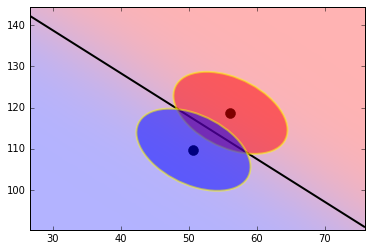

In [24]:
# plotting functions borrowed from http://scikit-learn.org/stable/auto_examples/classification/plot_lda_qda.html#sphx-glr-auto-examples-classification-plot-lda-qda-py

from matplotlib import colors
from scipy import linalg
import matplotlib as mpl

fig=plt.figure()
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)
# class 0 and 1 : areas
nx, ny = 200, 200
x_min, x_max = numpy.min(d[:,0]),numpy.max(d[:,0])
y_min, y_max = numpy.min(d[:,1]),numpy.max(d[:,1])
xx, yy = numpy.meshgrid(numpy.linspace(x_min, x_max, nx),
                     numpy.linspace(y_min, y_max, ny))
Z = clf.predict_proba(numpy.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
               norm=colors.Normalize(0., 1.))
plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='k')

# means
plt.plot(clf.means_[0][0], clf.means_[0][1],
         'o', color='black', markersize=10)
plt.plot(clf.means_[1][0], clf.means_[1][1],
'o', color='black', markersize=10)

def plot_ellipse(splot, mean, cov, color):
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = numpy.arctan(u[1] / u[0])
    angle = 180 * angle / numpy.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color, edgecolor='yellow',
                              linewidth=2, zorder=2)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)
    ax=splot.gca()
    ax.add_artist(ell)
    splot.canvas.draw()


def plot_lda_cov(lda, splot):
    plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
    plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')

plot_lda_cov(clf,fig)

#### Support vector machines

A commonly used classifier for fMRI data is the *support vector machine* (SVM).  The SVM uses a kernel to represent the distances between observations; this can be either linear or nonlinear.  The SVM then optimizes the boundary so as to minimize the distance between observations in each class.

/Users/poldrack/anaconda/envs/py34/lib/python3.4/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


accuracy = 0.730000
confusion matrix:
[[41  9]
 [18 32]]


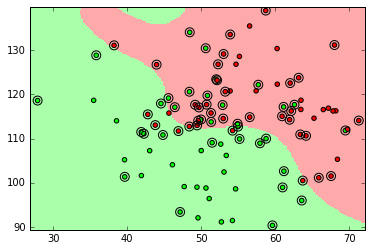

In [25]:
cl,d=make_class_data(multiplier=[1.1,1.1],N=n)
use_linear=False
if use_linear:
    clf=sklearn.svm.SVC(kernel='linear')
else:
    clf=sklearn.svm.SVC(kernel='rbf',gamma=0.01)

acc,confusion=classify(d,cl,clf,cv)
print('accuracy = %f'%acc)
print('confusion matrix:')
print(confusion)
fig=plot_cls_with_decision_surface(d,cl,clf)

# put wide borders around the support vectors
for sv in clf.support_vectors_:
    plt.scatter(sv[0],sv[1],s=80, facecolors='none', zorder=10)

Next we want to figure out what the right value of the gamma parameter is for the nonlinear SVM.  We can't do this by trying a bunch of gamma values and seeing which works best, because this overfit the data (i.e. cheating). Instead, what we need to do is use a *nested crossvalidation* in wich we use crossvalidation on the training data to find the best gamma parameter, and then apply that to the test data.  We can do this using the GridSearchCV() function in sklearn. See http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html#sphx-glr-auto-examples-model-selection-grid-search-digits-py for an example.

Best parameters:
Mean CV training accuracy: 0.847673474113
Mean CV test accuracy: 0.754666666667
gamma 0.0001
kernel rbf
C 1
Best parameters:
Mean CV training accuracy: 0.810047929981
Mean CV test accuracy: 0.7
gamma 0.01
kernel rbf
C 100
Best parameters:
Mean CV training accuracy: 0.831904001111
Mean CV test accuracy: 0.72
gamma 0.01
kernel rbf
C 10
Best parameters:
Mean CV training accuracy: 0.830306057238
Mean CV test accuracy: 0.728666666667
kernel linear
C 1000
Performance on out-of-sample test:
             precision    recall  f1-score   support

        0.0       0.65      0.82      0.73        50
        1.0       0.76      0.56      0.64        50

avg / total       0.70      0.69      0.68       100



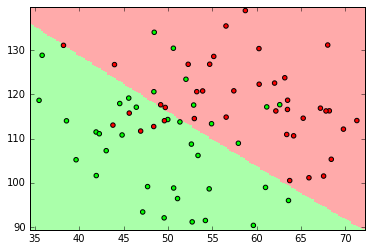

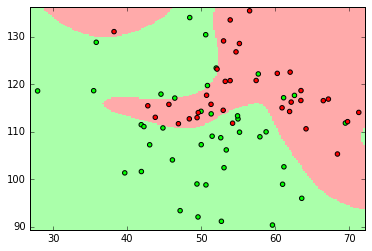

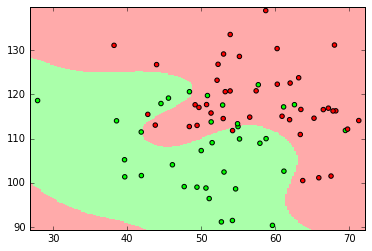

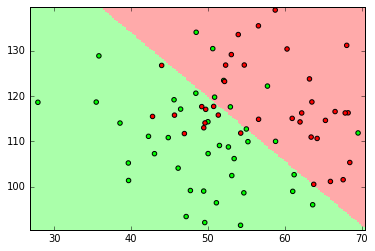

In [26]:
# do 4-fold cross validation
cv=KFold(4,shuffle=True)
# let's test both linear and rbf SVMs with a range of parameteter values
param_grid = [{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.1,0.01,0.001, 0.0001], 'kernel': ['rbf']}]

pred=numpy.zeros(cl.shape)
for train,test in cv.split(d):
    X_train=d[train,:]
    X_test=d[test,:]
    y_train=cl[train]
    y_test=cl[test]
    clf=GridSearchCV(sklearn.svm.SVC(C=1), param_grid, cv=5, scoring='accuracy')
    clf.fit(X_train,y_train)
    pred[test]=clf.predict(X_test)
    _=plot_cls_with_decision_surface(X_train,y_train,clf.best_estimator_)
    print('Best parameters:')
    print('Mean CV training accuracy:',numpy.mean(clf.cv_results_['mean_train_score']))
    print('Mean CV test accuracy:',numpy.mean(clf.cv_results_['mean_test_score']))
    for k in clf.best_params_:
        print(k,clf.best_params_[k])

print('Performance on out-of-sample test:')
print(classification_report(cl,pred))
